#### Load Libraries

In [12]:
!conda activate adil-eeg

/bin/bash: line 1: conda: command not found


In [1]:

# !pip install tensorflow
import tensorflow as tf
tf.config.list_physical_devices('gpu')

2022-10-13 01:54:03.751284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 01:54:03.859405: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 01:54:04.288041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tukl/anaconda3/envs/adil-eeg/lib/
2022-10-13 01:54:04.288092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

[]

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D,AvgPool2D, Dropout, Input, Convolution2D, ZeroPadding2D, Add, GlobalAveragePooling2D, concatenate,ReLU
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#### Confusion Matrix

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Set Path Variable

In [6]:
main_directory = '/home/tukl/EEG_group2/Images_Generated'
class_labels = ['normal', 'slowing-wave', 'spike-and-wave']

In [7]:

for cls in class_labels:
    bad_imgs = []
    img_dir = main_directory + '/' + cls
    for filename in os.listdir(img_dir):
        if filename.endswith('.png'):
            try:
                img = Image.open(img_dir + '/' + filename ) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                bad_imgs.append(filename)
                print('Bad file:', filename) # print out the names of corrupt files
                os.remove(img_dir + '/' + filename)
    print('Amount of Bad Images in Dataset :',len(bad_imgs))

Amount of Bad Images in Dataset : 0
Amount of Bad Images in Dataset : 0
Amount of Bad Images in Dataset : 0


#### Data Processing

In [8]:
random.seed(444)



# Organize into test, train and validations folders

os.chdir(main_directory)

if os.path.isdir('train/normal') is False:
    os.makedirs('train/normal')
    os.makedirs('train/spike-and-wave')
    os.makedirs('train/slowing-wave')

    os.makedirs('valid/normal')
    os.makedirs('valid/spike-and-wave')
    os.makedirs('valid/slowing-wave')

    os.makedirs('test/normal')
    os.makedirs('test/spike-and-wave')
    os.makedirs('test/slowing-wave')
    
    capped_size = 70000
    len_normal = len(os.listdir(main_directory + '/' + 'normal'))
    len_spw = len(os.listdir(main_directory + '/' + 'spike-and-wave'))
    len_sw = len(os.listdir(main_directory + '/' + 'slowing-wave'))
    print('Amoount of imgs in dataset: ',len_normal,len_spw,len_sw)
    
    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.7)):
        shutil.move(c, 'train/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.7)):
        shutil.move(c, 'train/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.7)):
        shutil.move(c, 'train/slowing-wave')

    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.15)):
        shutil.move(c, 'valid/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.15)):
        shutil.move(c, 'valid/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.15)):
        shutil.move(c, 'valid/slowing-wave')

    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.15)):
        shutil.move(c, 'test/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.15)):
        shutil.move(c, 'test/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.15)):
        shutil.move(c, 'test/slowing-wave')

os.chdir('../../')

#### Image Processing

In [9]:
train_path = main_directory + '/train' + '/'
valid_path = main_directory + '/valid' + '/'
test_path = main_directory + '/test' + '/'

In [10]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), classes = class_labels, batch_size = 16, shuffle = True)
valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = class_labels, batch_size = 8)
test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), classes = class_labels, batch_size = 8, shuffle = False)
print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

Found 496771 images belonging to 3 classes.
Found 106450 images belonging to 3 classes.
Found 106450 images belonging to 3 classes.
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}


In [12]:
assert train_batches.n > 0
assert valid_batches.n > 0
assert test_batches.n > 0
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

#### Plot Images

In [13]:
from PIL import Image
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
imgs, train_labels = next(train_batches)

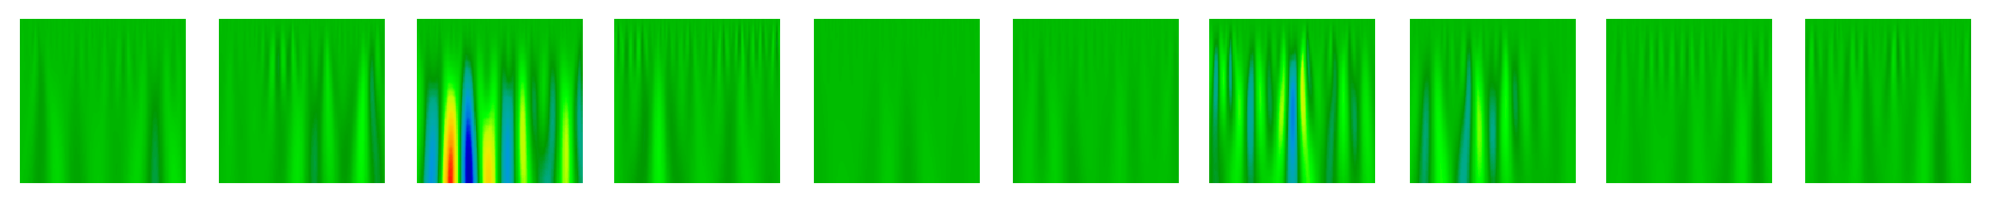

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
plotImages(imgs) 
print(train_labels)

In [16]:
imgs[0].shape

(224, 224, 3)

# Model Implementation

### Prepare Callbacks

In [17]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

In [19]:

os.chdir(main_directory)

In [21]:
checkpoint_filepath = 'home/tukl/EEG_group2/Images_Generated'
mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

## Google LeNEt

In [22]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

google_lenet = GoogLeNet()

google_lenet.summary()

2022-10-13 01:58:57.555445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 01:58:57.555872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:58:57.555990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:58:57.556064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

                                                                                                  
 conv2d_24 (Conv2D)             (None, 12, 12, 224)  226016      ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 12, 12, 64)   38464       ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 12, 12, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 concatenate_3 (Concatenate)    (None, 12, 12, 512)  0           ['conv2d_22[0][0]',              
                                                                  'conv2d_24[0][0]',              
                                                                  'conv2d_26[0][0]',              
          

 conv2d_51 (Conv2D)             (None, 5, 5, 128)    102528      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 5, 5, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 5, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 5, 5, 192)    159936      ['concatenate_7[0][0]']          
          

In [74]:
#google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [23]:
###### Train Model

google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

history_6 = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

Epoch 1/30


2022-10-13 01:59:32.342571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-13 01:59:33.287983: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-13 01:59:33.288353: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-13 01:59:33.288370: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-13 01:59:33.288719: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-13 01:59:33.288757: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-13 01:59:34.031925: I tensorflow/stream_executor/cuda/c

31049/31049 [==============================] - 835s 27ms/step - loss: 1.6123 - dense_4_loss: 0.5312 - dense_1_loss: 0.5480 - dense_3_loss: 0.5331 - dense_4_accuracy: 0.7743 - dense_1_accuracy: 0.7660 - dense_3_accuracy: 0.7732 - val_loss: 1.4409 - val_dense_4_loss: 0.4800 - val_dense_1_loss: 0.4840 - val_dense_3_loss: 0.4768 - val_dense_4_accuracy: 0.8010 - val_dense_1_accuracy: 0.7972 - val_dense_3_accuracy: 0.8017
Epoch 2/30
31049/31049 [==============================] - 821s 26ms/step - loss: 1.3637 - dense_4_loss: 0.4481 - dense_1_loss: 0.4640 - dense_3_loss: 0.4516 - dense_4_accuracy: 0.8142 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8131 - val_loss: 1.3060 - val_dense_4_loss: 0.4322 - val_dense_1_loss: 0.4424 - val_dense_3_loss: 0.4314 - val_dense_4_accuracy: 0.8201 - val_dense_1_accuracy: 0.8175 - val_dense_3_accuracy: 0.8209
Epoch 3/30
31049/31049 [==============================] - 811s 26ms/step - loss: 1.2815 - dense_4_loss: 0.4200 - dense_1_loss: 0.4377 - dense_3_loss:

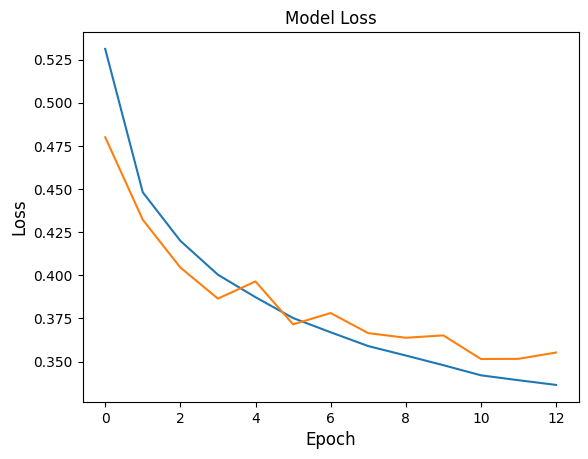

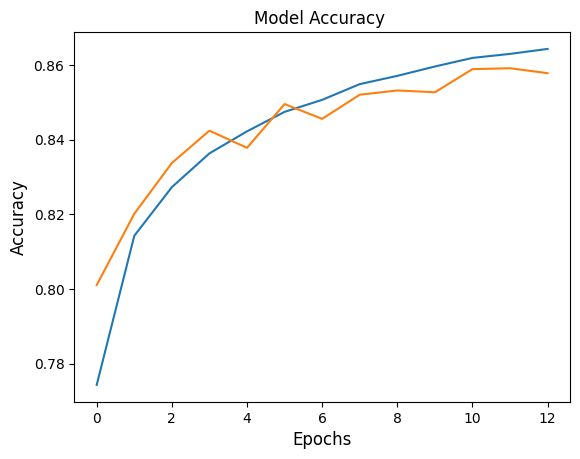

In [26]:
###### Model Plots

plt.plot(history_6.history['dense_4_loss'])
plt.plot(history_6.history['val_dense_4_loss'])
plt.title('Model Loss',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.show()

plt.plot(history_6.history['dense_4_accuracy'])
plt.plot(history_6.history['val_dense_4_accuracy'])
plt.title('Model Accuracy ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xlabel('Epochs',fontsize=12)
plt.show()

#### Save Model

In [27]:
google_lenet.save('/home/tukl/EEG_group2/model/google-net/GoogLenet_-final.h5')

In [28]:
google_lenet.save_weights('/home/tukl/EEG_group2/model/google-net/GoogLenet_-final.tf', save_format='tf')

13307/13307 [==============================] - 104s 8ms/step - loss: 1.0918 - dense_4_loss: 0.3575 - dense_1_loss: 0.3741 - dense_3_loss: 0.3602 - dense_4_accuracy: 0.8563 - dense_1_accuracy: 0.8500 - dense_3_accuracy: 0.8548
13307/13307 - 87s - 87s/epoch - 7ms/step
Confusion matrix, without normalization
[[58246  4048  1556]
 [ 2805 19857  1763]
 [ 2506  3294 12375]]


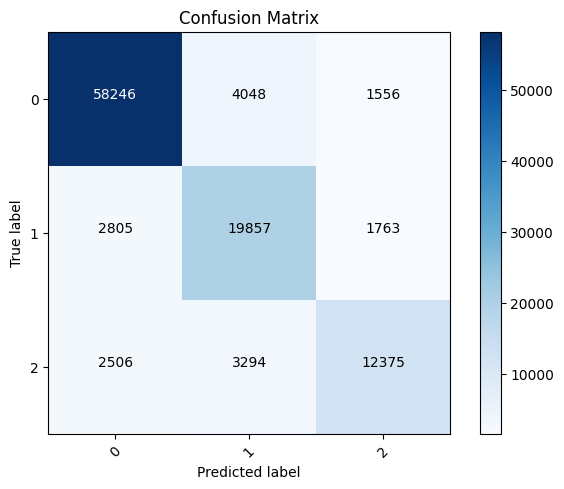

In [29]:
###### Test Model

google_lenet.evaluate(test_batches)

predictions_6 = google_lenet.predict(test_batches, verbose = 2)

y_pred = np.argmax(predictions_6[1], axis = 1)
y_test=test_batches.classes

cm = confusion_matrix(y_test, y_pred)

cm_plot_labels = [0, 1, 2]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [31]:
accuracy_score(y_test, y_pred)

0.8499577266322217

In [32]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names,digits = 5))

              precision    recall  f1-score   support

     class 0    0.91644   0.91223   0.91433     63850
     class 1    0.73006   0.81298   0.76929     24425
     class 2    0.78852   0.68088   0.73076     18175

    accuracy                        0.84996    106450
   macro avg    0.81167   0.80203   0.80479    106450
weighted avg    0.85183   0.84996   0.84971    106450



## Vgg16

In [33]:
##### VGG16

###### Import and Build Model

vgg16_model = keras.applications.vgg16.VGG16()

model_2 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model_2.add(layer)

# for layer in model.layers:
#     layer.trainable = False

model_2.add(Dense(3, activation = 'softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Epoch 1/30
31049/31049 [==============================] - 3237s 104ms/step - loss: 0.4889 - accuracy: 0.7967 - val_loss: 0.4366 - val_accuracy: 0.8225
Epoch 2/30
31049/31049 [==============================] - 3203s 103ms/step - loss: 0.4176 - accuracy: 0.8294 - val_loss: 0.4014 - val_accuracy: 0.8366
Epoch 3/30
31049/31049 [==============================] - 3250s 105ms/step - loss: 0.3932 - accuracy: 0.8389 - val_loss: 0.4102 - val_accuracy: 0.8305
Epoch 4/30
31049/31049 [==============================] - 3185s 103ms/step - loss: 0.3787 - accuracy: 0.8462 - val_loss: 0.3836 - val_accuracy: 0.8426
Epoch 5/30
31049/31049 [==============================] - 3199s 103ms/step - loss: 0.3676 - accuracy: 0.8509 - val_loss: 0.3600 - val_accuracy: 0.8549
Epoch 6/30
31049/31049 [==============================] - 3185s 103ms/step - loss: 0.3613 - accuracy: 0.8544 - val_loss: 0.3591 - val_accuracy: 0.8535
Epoch 7/30
31049/31049 [==============================] - 3192s 103ms/step - loss: 0.3541 - ac

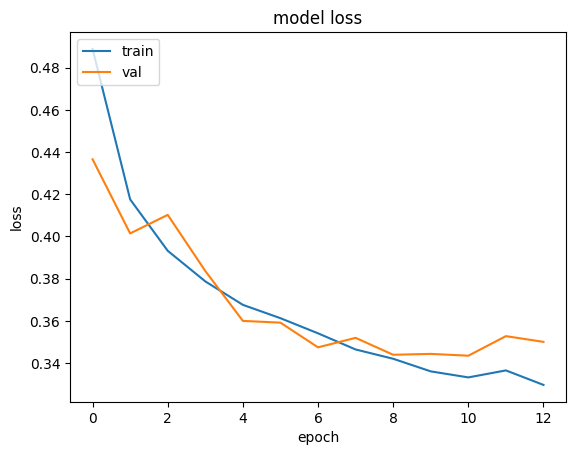

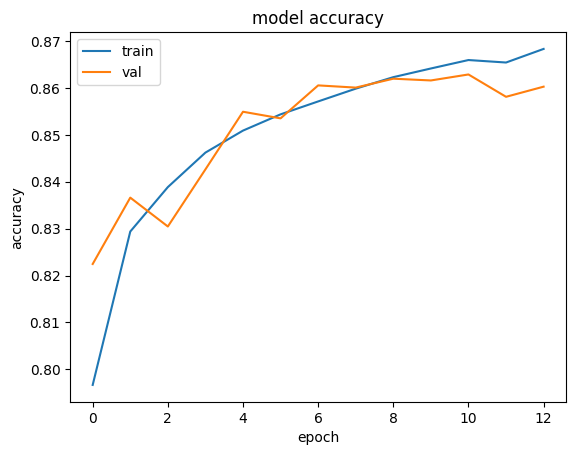

In [34]:
###### Train Model

model_2.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history_2 = model_2.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### save model

In [35]:
model_2.save('/home/tukl/EEG_group2/model/vgg16/VGG16_baseline.h5')

In [36]:
model_2.save_weights('/home/tukl/EEG_group2/model/vgg16/VGG16_baseline.tf', save_format='tf')

13307/13307 [==============================] - 232s 17ms/step - loss: 0.3487 - accuracy: 0.8605
13307/13307 - 207s - 207s/epoch - 16ms/step
Confusion matrix, without normalization
[[59000  3148  1702]
 [ 3045 19003  2377]
 [ 2125  2449 13601]]


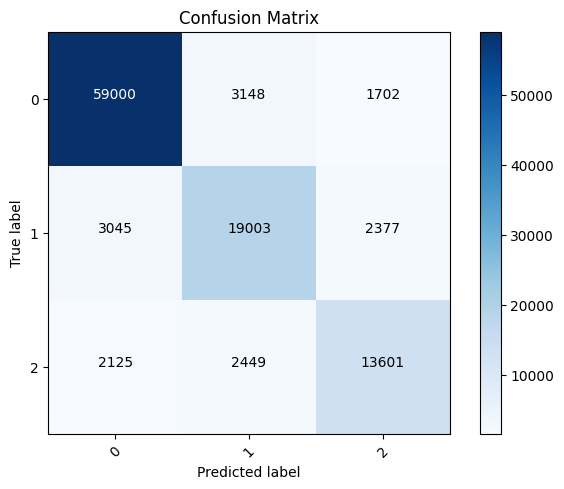

In [37]:
###### Test Model

model_2.evaluate(test_batches)

predictions_2 = model_2.predict(test_batches, verbose = 2)

y_test=test_batches.classes
y_pred = np.argmax(predictions_2, axis = 1)

accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

cm_plot_labels = [0, 1, 2]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [38]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     class 0    0.91943   0.92404   0.92173     63850
     class 1    0.77248   0.77801   0.77524     24425
     class 2    0.76929   0.74834   0.75867     18175

    accuracy                        0.86054    106450
   macro avg    0.82040   0.81680   0.81854    106450
weighted avg    0.86008   0.86054   0.86028    106450



END

**Signed By:**

Muiz Alvi